<a href="https://colab.research.google.com/github/aaditkamat/data-analysis-projects/blob/add-linkfire-project/Website_Traffic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS

## Explore the data

In [2]:
traffic_data = pd.read_csv('traffic.csv')
# Output the first 5 rows of the dataset
traffic_data.head()

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8


In [3]:
# Get metadata describing the dataset
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226278 entries, 0 to 226277
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   event    226278 non-null  object
 1   date     226278 non-null  object
 2   country  226267 non-null  object
 3   city     226267 non-null  object
 4   artist   226241 non-null  object
 5   album    226273 non-null  object
 6   track    226273 non-null  object
 7   isrc     219157 non-null  object
 8   linkid   226278 non-null  object
dtypes: object(9)
memory usage: 15.5+ MB


It seems like there are some null values for country, city, artist, album, track and isrc

## Pageview analysis

In [5]:
# What are the event type?
traffic_data['event'].value_counts()

,count
event,
pageview,142015
click,55732
preview,28531


Based on this we can see that there are a total of 142,015 page view events received in the full period.

In [16]:
# How many pageview events are there by day
traffic_data[traffic_data['event'] == 'pageview'].groupby('date')['event'].count().reset_index().rename(columns = {'event': 'pageview_counts'})

,date,pageview_counts
0,2021-08-19,22366
1,2021-08-20,21382
2,2021-08-21,21349
3,2021-08-22,20430
4,2021-08-23,18646
5,2021-08-24,18693
6,2021-08-25,19149


## Daily analysis of other recorded events

In [17]:
# Other recorded events counted by day
traffic_data[traffic_data['event'] != 'pageview'].groupby(['date', 'event'])['country'].count().reset_index().rename(columns = {'country': 'event_counts'})

,date,event,event_counts
0,2021-08-19,click,9207
1,2021-08-19,preview,3788
2,2021-08-20,click,8508
3,2021-08-20,preview,4222
4,2021-08-21,click,8071
5,2021-08-21,preview,4663
6,2021-08-22,click,7854
7,2021-08-22,preview,4349
8,2021-08-23,click,7314
9,2021-08-23,preview,3846


## Country analysis

In [19]:
# Find countries that are not filled, and see if their values can be inferred based on city
traffic_data[(traffic_data['country'].isna()) & (~traffic_data['city'].isna())]

,event,date,country,city,artist,album,track,isrc,linkid


Where country is blank, city is also blank (their non-null counts are the same as well)

In [25]:
# Group pageviews by country
traffic_data[traffic_data['event'] == 'pageview'].groupby('country')['event'].count().reset_index().rename(columns={'event': 'count'}).sort_values(by = 'count', ascending = False)

,country,count
166,Saudi Arabia,28873
88,India,27286
201,United States,20839
65,France,9674
91,Iraq,4897
...,...,...
38,Central African Republic,1
206,Wallis and Futuna,1
155,Principality of Monaco,1
163,Saint Martin,1


It seems that most of the page views came from Saudi Arabia, India and United States.

## Click rate analysis

In [30]:
## Calculate click rate

# Get number of clicks
clicks = traffic_data[traffic_data['event'] == 'click']['event'].count()
# Get number of pageviews
pageviews = traffic_data[traffic_data['event'] == 'pageview']['event'].count()
# Calculate CTR
ctr = clicks / pageviews
f'Click rate is: {ctr}'

'Click rate is: 0.3924374185825441'

In [46]:
# Get counts by linkid and event for clicks and pageviews
link_distribution = traffic_data[traffic_data['event'].isin(['click', 'pageview'])].groupby(['linkid', 'event'])['date'].count().reset_index().rename(columns = {'date': 'count'})
# Pivot based on event to calculate CTR per link
link_distribution = link_distribution.pivot(index = 'linkid', columns = 'event', values = 'count').reset_index()
link_distribution['ctr'] = np.round(link_distribution['click'] * 100/ link_distribution['pageview'], 2)
link_distribution = link_distribution[['linkid', 'ctr']].dropna()
link_distribution

event,linkid,ctr
1,00126b32-0c35-507b-981c-02c80d2aa8e7,100.00
6,004b9724-abca-5481-b6e9-6148a7ca00a5,100.00
9,0063a982-41cd-5629-96d0-e1c4dd72ea11,66.67
10,006af6a0-1f0d-4b0c-93bf-756af9071c06,22.22
11,00759b81-3f04-4a61-b934-f8fb3185f4a0,75.00
...,...,...
3831,ffd8d5a7-91bc-48e1-a692-c26fca8a8ead,34.52
3834,fff38ca0-8043-50cd-a5f1-f65ebb7105c5,100.00
3836,fff84c0e-90a1-59d8-9997-adc909d50e16,100.00
3837,fffc17a7-f935-5d3e-bd3e-d761fd80d479,50.00


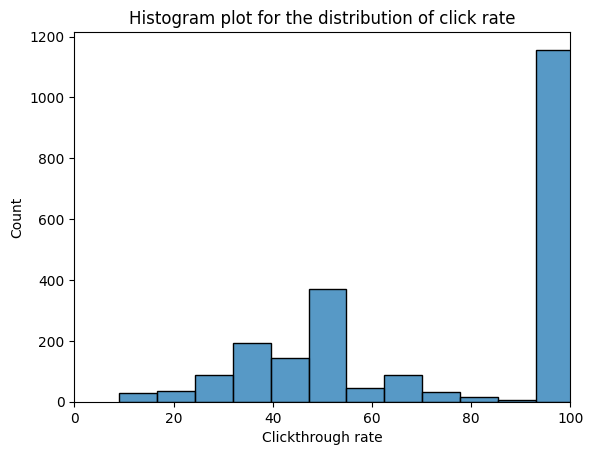

In [48]:
fig, ax = plt.subplots()
ax.set_ylabel('Count')
ax.set_xlabel('Clickthrough rate')
ax.set_title('Histogram plot for the distribution of click rate')
ax.set_xlim(0, 100)
sns.histplot(data = link_distribution, x = 'ctr')
plt.show()

A lot of the links have 100% click rate, while some of them have 50% (only half of the links that were clicked were viewed)

## Correlation analysis (Linear relationship)

event       click   preview
event                      
click    1.000000  0.993422
preview  0.993422  1.000000


<Axes: xlabel='click', ylabel='preview'>

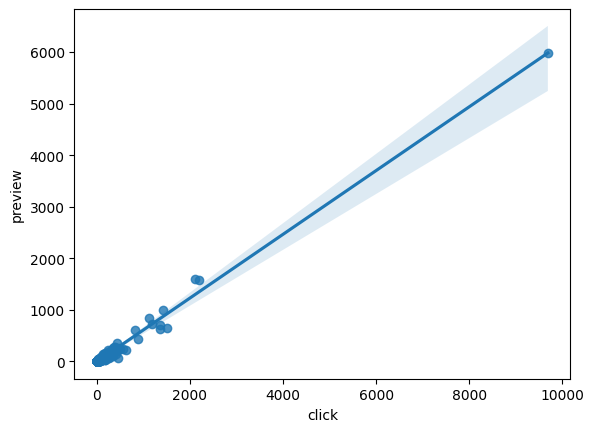

In [56]:
# Calculate the correlation between clicks and previews on a link
# Get click and previews per link
link_distribution = traffic_data[traffic_data['event'].isin(['click', 'preview'])].groupby(['linkid', 'event'])['date'].count().reset_index().rename(columns = {'date': 'count'})
link_distribution = link_distribution.pivot(index = 'linkid', columns = 'event', values = 'count').reset_index()
# Calculate correlation coefficient for clicks and previews
print(link_distribution[['click', 'preview']].corr())
# Plot regression line between clicks and previews
sns.regplot(data=link_distribution, x = 'click', y = 'preview')


In [54]:
# Get the statistical values for the regression line using least squares and output the result
link_distribution = link_distribution.dropna()
X = link_distribution['click']
y = link_distribution['preview']
model = OLS(y, X)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                preview   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          3.511e+04
Date:                Sat, 01 Feb 2025   Prob (F-statistic):                        0.00
Time:                        17:41:19   Log-Likelihood:                         -2322.9
No. Observations:                 464   AIC:                                      4648.
Df Residuals:                     463   BIC:                                      4652.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
click          0.6152      0.003    187.381      0.000       0.609       0.622
==============================================================================
Omnibus:                      153.379   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15129.811
Skew:                           0.243   Prob(JB):                         0.00
Kurtosis:                      30.970   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the high value of R^2 and low probability that this result is no significant using both t and F-statistic, I'd say that there is a significant correlation that implies a linear relationship between the two events

## Heatmap analysis (Categorical relationship)

<Axes: xlabel='preview', ylabel='click'>

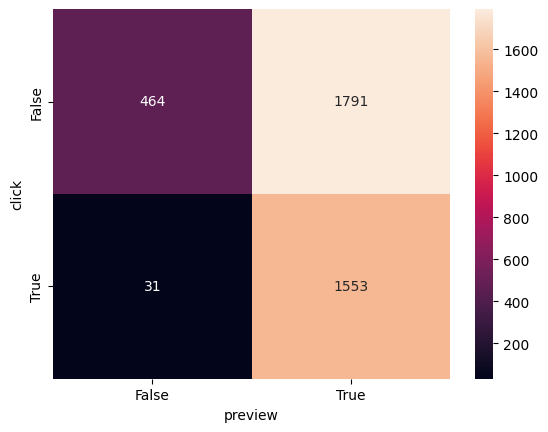

In [89]:
# Check the categorical relationship between clicks and previews
# Get all events per link
link_distribution = traffic_data.groupby(['linkid', 'event'])['date'].count().reset_index().rename(columns = {'date': 'count'})
link_distribution = link_distribution.pivot(index = 'linkid', columns = 'event', values = 'count').reset_index()
# Create a cross tabulation between clicks and previews to see categorical relationship
is_clicked = link_distribution['click'].isna()
is_previewed = link_distribution['preview'].isna()
table = pd.crosstab(is_clicked, is_previewed)
sns.heatmap(table, annot=True, fmt='.0f')

When we explore the categorical relationship betwee clicking and previewing, we see that many of links are previewed regardless of whether they are clicked or not. In fact, more links are previewed and not clicked than previewed and clicked.